# NCSU GIS/MEA582: Geospatial Modeling and Anaylsis

In [1]:
import sys
v = sys.version_info
print(f"We are using Python {v.major}.{v.minor}.{v.micro}")

We are using Python 3.10.6


Set up your GRASS environment

In [3]:
!grass -c -e ~/grassdata/nc_spm_08_grass7/HW_interpolation_1

Starting GRASS GIS...
Creating new GRASS GIS mapset <HW_interpolation_1>...

          __________  ___   __________    _______________
         / ____/ __ \/   | / ___/ ___/   / ____/  _/ ___/
        / / __/ /_/ / /| | \__ \\_  \   / / __ / / \__ \
       / /_/ / _, _/ ___ |___/ /__/ /  / /_/ // / ___/ /
       \____/_/ |_/_/  |_/____/____/   \____/___//____/

Welcome to GRASS GIS 8.3.dev (c1b1ff69d)
GRASS GIS homepage:                      https://grass.osgeo.org
This version running through:            Bash Shell (/bin/bash)
Help is available with the command:      g.manual -i
See the licence terms with:              g.version -c
See citation options with:               g.version -x
If required, restart the GUI with:       g.gui wxpython
When ready to quit enter:                exit

Launching <wxpython> GUI in the background, please wait...
To run a command as administrator (user "root"), use "sudo <command>".
See "man sudo_root" for details.

GRASS nc_spm_08_grass7/HW_interpolatio

In [3]:
# Import Python standard library and IPython packages we need.
import subprocess
import sys
import matplotlib.pyplot as plt
from PIL import Image


# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
session = gj.init("~/Documents/grassdata", "nc_spm_08_grass7", "HW_interpolation_1")


## Spatial interpolation and approximation I: methods (4A)

### Compute Voronoi polygons

- Display the polygons with centroids.
- Find the column name where z is stored and convert the polygons to raster.
- Compute aspect to evaluate the surface geometry. 

In [116]:
%%bash
g.region rural_1m -p
v.voronoi elev_lid792_randpts output=elev_vor

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      1
ewres:      1
rows:       750
cols:       700
cells:      525000


Reading features...
Voronoi triangulation for 6000 points...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing edges...
Writing features...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Writing attributes...
Searching for topology errors...
Cleaning output topology
Reading features...
Snap vertices Pass 1: select points
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Snap vertices Pass 2: assign anchor vertices
   4   9  14  19  24  29  34  39  44  49  54  59  64  69  74  79  84  89  94  99 100
Snap vertices Pass 3: snap to assigned points
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
   0   2   4   6   8  10  12  

Display the voroni map

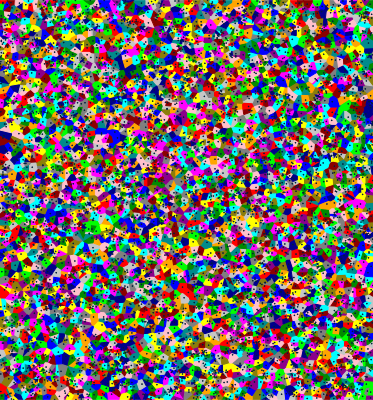

In [6]:
# Create Map instance
voronoi_map = gj.Map()
# Add a vector to the map
voronoi_map.d_vect(map="elev_vor", size=1, flags="c", type="area,centroid")
# Display map
voronoi_map.show()

Find the column name where z is stored and convert the polygons to raster.

In [7]:
!v.info -c elev_vor

Displaying column types/names for database connection of layer <1>:
INTEGER|cat
DOUBLE PRECISION|value


Compute aspect to evaluate the surface geometry. 

In [8]:
%%bash
v.to.rast elev_vor output=elev_vor_1m attrcolumn=value use=attr
r.colors elev_vor_1m color=elevation
r.slope.aspect elevation=elev_vor_1m aspect=asp_vor_1m

Reading areas...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
v.to.rast complete.
Color table for raster map <elev_vor_1m> set to 'elevation'
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Aspect raster map <asp_vor_1m> complete


Display the resulting elevation map and aspect map. 

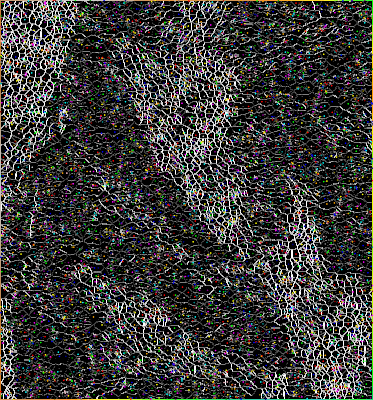

In [10]:
# Create Map instance
elevation_map = gj.Map(filename="output/elev_voronoi.png")
# Add the elevation raster to the map
elevation_map.d_rast(map="elev_vor_1m")
# Add the aspect raster to the map
elevation_map.d_rast(map="asp_vor_1m")
elevation_map.d_vect(map="elev_lid792_randpts", size=1, flags="c", color="red")
# Display map
elevation_map.show()

Optionally, you can view it in 3D perspective (switch off all layers except for elev_vor_1m and switch to 3D view). 

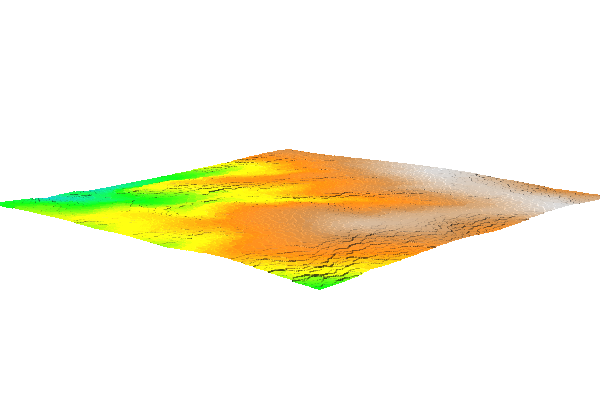

In [19]:
# Create Map instance
elevation_map3d = gj.Map3D(filename="output/elev_vor_1m_3D.png")
# Add the elevation raster to the map
elevation_map3d.render(elevation_map="elev_vor_1m", color_map="elev_vor_1m", perspective=20)
elevation_map3d.show()

### Interpolation using IDW

- Set region and resolution, find a column name where z is stored.
- Interpolate DEM using IDW, check the result using aspect. 

In [20]:
%%bash
g.region rural_1m -p
v.info -c elev_lid792_randpts
v.surf.idw elev_lid792_randpts output=elev_idw_1m column=value
r.colors elev_idw_1m color=elevation
r.slope.aspect elevation=elev_idw_1m aspect=asp_idw_1m

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      1
ewres:      1
rows:       750
cols:       700
cells:      525000


Displaying column types/names for database connection of layer <1>:


INTEGER|cat
DOUBLE PRECISION|value


6000 points loaded
Interpolating raster map <elev_idw_1m> (750 rows, 700 columns)...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
v.surf.idw complete.
Color table for raster map <elev_idw_1m> set to 'elevation'
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Aspect raster map <asp_idw_1m> complete


Display the idw map

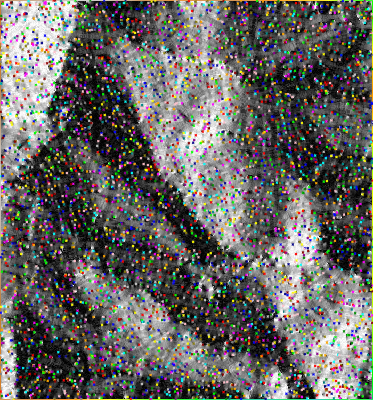

In [21]:
# Create Map instance
idw_map = gj.Map(filename="output/elev_idw.png")
# Add the elevation raster to the map
idw_map.d_rast(map="elev_idw_1m")
# Add the aspect raster to the map
idw_map.d_rast(map="asp_idw_1m")
idw_map.d_vect(map="elev_lid792_randpts", size=2, flags="c", color="red")
# Display map
idw_map.show()

Design experiment that elucidates the impact of IDW parameters on the surface, focus on the impact of:


    - exponent e.g., power=0.5, 1, 5 (2 is the default)
    - number of neighboring points e.g., npoint=1, 5, 20, 60 (12 is the default)

Include selected images (e.g. hillshade or aspect) and relevant stats (e.g., mean, min, max from r.univar, histogram) that highlight the differences in the resulting surfaces into your report.

Check the surface interpolated with default parameters using 3D view.

> Do not forget to switch off everything except for the interpolated elevations and set fine resolution to 1.

You can use constant color for the surface to highlight its structure.

Save an image for your report. 

In [122]:

def create_histogram(raster, filename):
    hist_img = gj.Map(filename=filename)
    hist_img.d_histogram(map=raster)
    hist_img.show()
    return filename

def create_map(elevation, aspect, filename):
    # Create Map instance
    idw_map = gj.Map(filename=filename)
    # Add the elevation raster to the map
    idw_map.d_rast(map=elevation)
    # Add the aspect raster to the map
    idw_map.d_rast(map=aspect)
    idw_map.d_vect(map="elev_lid792_randpts", size=2, flags="c", color="red")
    # Display map
    idw_map.show()
    return filename
    
def get_stats(elevation):
    univar = gs.parse_command("r.univar", map=elevation, flags="ge")
    min_val = float(univar["min"])
    max_val = float(univar["max"])
    mean_val = float(univar["max"])
    return {"min": min_val, "max": max_val, "mean": mean_val}
    

power=[0.5, 1, 2, 3, 5]
npoint=[1, 5, 20, 60]

def run_idw_experiment(power=[0.5, 1, 2, 3, 5], npoint=[1, 5, 20, 60]):
    gs.run_command("g.region", region="rural_1m", flags="p")
    tmp = []
    current_row = 0
    current_col = 0

    for p in power:
        for n in npoint:
            elev_output = f"elev_idw_1m_pow{p}_np{n}"
            aspect_output = f"asp_idw_1m_pow{p}_np{n}"
            image_output = f"output/elev_idw_pow{p}_np{n}.png"
            hist_output = f"output/hist_elev_idw_pow{p}_np{n}.png"
            gs.run_command("v.surf.idw", input="elev_lid792_randpts", output=elev_output, column="value", power=p, npoint=n)
            gs.run_command("r.colors", map=elev_output, color="elevation")
            gs.run_command("r.slope.aspect", elevation=elev_output, aspect=aspect_output)

            stats = get_stats(elev_output)
            create_map(elev_output, aspect_output, image_output)
            create_histogram(elev_output,hist_output)

            results = {
                "power": p,
                "npoint": n,
                "row": current_row,
                "column": current_col,
                "elevation": elev_output,
                "aspect": aspect_output,
                "image": image_output,
                "histogram": hist_output,
                "stats": stats
            }
            tmp.append(results)
            current_col = current_col + 1
            if current_col == columns:
                current_col = 0

        current_row = current_row + 1
        if current_row == rows:
            current_row = 0
        
    return tmp
        
        

In [ ]:
power=[0.5, 1, 2, 3, 5]
npoint=[1, 5, 20, 60]
runs = run_idw_experiment(power=power, npoint=npoint)

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      1
ewres:      1
rows:       750
cols:       700
cells:      525000
Rows: 5, Columns: 4


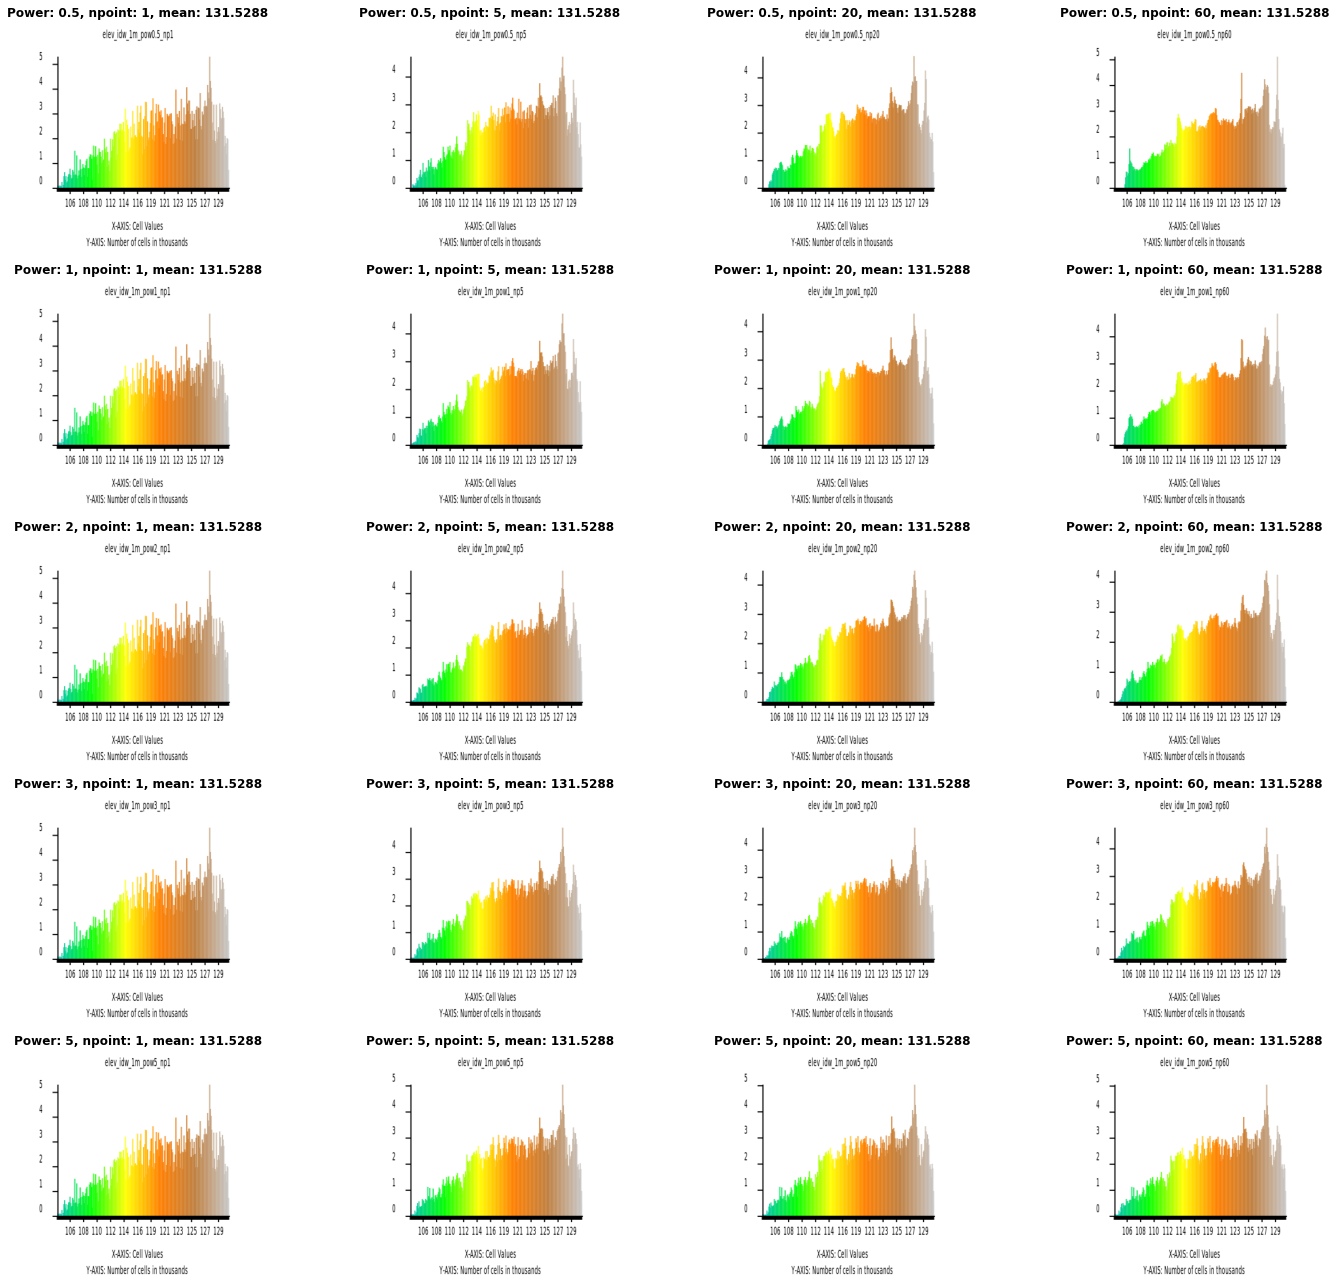

In [123]:
power=[0.5, 1, 2, 3, 5]
npoint=[1, 5, 20, 60]
runs = run_idw_experiment(power=power, npoint=npoint)
fig = plt.figure(figsize=(20, 18))
columns = len(npoint)
rows = len(power)
print(f"Rows: {rows}, Columns: {columns}")
grs = fig.add_gridspec(nrows=rows, ncols=columns) # Row, Column

for run in runs:
    ax1 = fig.add_subplot(grs[run['row'], run['column']])
    ax1.axis('off')
    fig.subplots_adjust(hspace=0, wspace=0.5)
    img1 = Image.open(run["histogram"])
    imgplot = plt.imshow(img1)
    ax1.set_title(f"Power: {run['power']}, npoint: {run['npoint']}, mean: {run['stats']['mean']:.4f}",{"fontsize":12, "fontweight":"bold"})
    
    
plt.tight_layout()
plt.savefig("output/idw_hist_experiment.png",bbox_inches='tight', dpi=300)

In [ ]:
fig = plt.figure(figsize=(20, 18))
columns = len(npoint)
rows = len(power)
grs = fig.add_gridspec(nrows=rows, ncols=columns) # Row, Column
for run in runs:
    ax1 = fig.add_subplot(grs[run['row'], run['column']])
    ax1.axis('off')
    fig.subplots_adjust(hspace=0, wspace=0.5)
    img1 = Image.open(run["image"])
    imgplot = plt.imshow(img1)
    ax1.set_title(f"Power: {run['power']}, npoint: {run['npoint']}, mean: {run['stats']['mean']:.4f}",{"fontsize":12, "fontweight":"bold"})
       
plt.tight_layout()
plt.savefig("output/idw_elev_map_experiment.png",bbox_inches='tight', dpi=300)

### Compute DEM from contours

Compute DEM from contours using linear interpolation between isolines: 

In [57]:
%%bash

g.region rural_1m -p
v.to.rast elev_lid792_cont1m output=el_lid792_cont1m attrcolumn=level use=attr
r.surf.contour el_lid792_cont1m output=el_rcont
r.colors el_rcont color=elevation

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      1
ewres:      1
rows:       750
cols:       700
cells:      525000


Reading features...
   2   5   8  12  15  19  23  26  30  34  38  41  45  49  52  56  60  63  67  71  75  78  82  86  89  93  97 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
v.to.rast complete.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Color table for raster map <el_rcont> set to 'elevation'


Check the result using a 2D aspect map or view el_rcont in 3D.
In 3D set view from SE and light from NW to reveal subtle geometry. 

In [58]:
!r.slope.aspect elevation=el_rcont aspect=asp_rcont

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Aspect raster map <asp_rcont> complete


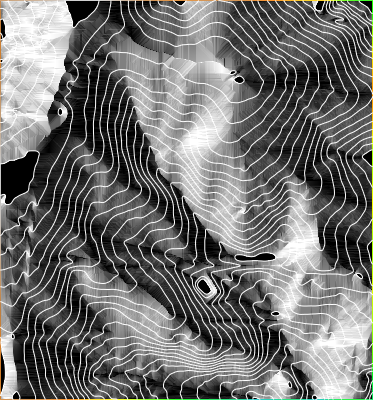

In [59]:
# Create Map instance
asp_rcont_map = gj.Map(filename="output/asp_rcont.png")
# Add the elevation raster to the map
asp_rcont_map.d_rast(map="el_rcont")
# Add the aspect raster to the map
asp_rcont_map.d_rast(map="asp_rcont")
asp_rcont_map.d_vect(map="elev_lid792_cont1m", col="white")
# Display map
asp_rcont_map.show()

#### Optional: create TIN model

Convert z-value stored as attribute "value" to z-coordinate.

Compute TIN:

In [60]:
%%bash

v.to.3d elev_lid792_randpts output=elev_lid792_randpts3d column=value
v.delaunay elev_lid792_randpts3d output=elev_rand_tin
r.mapcalc "level90 = 90"

Fetching height from <value> column...
Transforming features...
Copying attributes... 30      40      50      60
Building topology for vector map
<elev_lid792_randpts3d@HW_interpolation_1>...
Registering primitives...
Vertical extent of vector map <elev_lid792_randpts3d>: B: 103.969032 T:
131.528778
Reading point features...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Writing edges...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Building topology for vector map <elev_rand_tin@HW_interpolation_1>...
Registering primitives...
Building areas...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Calculating area centroids...
   2   5   8  11  14  17  20

Visualize the TIN as 3D vector data:
    
Keep only "level90" and "elev_rand_tin" switched on (remove or uncheck everything else).

Switch the view from 2D to 3D. Go to Data > Vector and unckeck Show vector points. In Vector lines, change color from black to gray and set Display from on surface to as 3D. 

#### Optional: Use Python to create the data for IDW comparison

In [62]:
for npoints in [1, 20]:
    name = 'elev_idw_1m_npoints_{}'.format(npoints)
    stats = gs.parse_command('v.surf.idw', input='elev_lid792_randpts',
                             output=name, column='value', npoints=npoints)

Computing statistics but showing only some for different number of points (you can combine the code with the code above): 

In [65]:
for npoints in [1, 20]:
    name = 'elev_idw_1m_npoints_{}'.format(npoints)
    print("\n\n")
    print(name)
    print(len(name) * "=")
    stats = gs.parse_command('r.univar', map=name, flags='eg')

    print(stats['min'], stats['max'])




elev_idw_1m_npoints_1
103.969032 131.528778



elev_idw_1m_npoints_20
103.969032 131.528778


 Setting the color table and computing shaded relief for changing power (you need to create the maps before that): 

In [67]:
for power in [0.5, 1, 2, 5]:
    name = 'elev_idw_1m_power_{}'.format(power)
    stats = gs.parse_command('v.surf.idw', input='elev_lid792_randpts',
                             output=name, column='value', power=power)
    gs.run_command('r.colors',
        map=name,
        color='elevation')
    gs.run_command('r.relief',
        input=name,
        output='elev_idw_1m_power_{}_relief'.format(power))
    gs.run_command('r.shade',
        color=name,
        shade='elev_idw_1m_power_{}_relief'.format(power),
        output='elev_idw_1m_power_{}_shaded'.format(power))

Creating a PNG image with histogram for changing power: 

In [75]:
for power in [0.5, 1, 2, 5]:
    name = 'elev_idw_1m_power_{}'.format(power)
    power_hist = gj.Map(filename=f"output/hist_{name}.png")
    power_hist.d_histogram(map=name)
    power_hist.show()

Here are two commands often used when using the scripts. First is setting the computational. We can do that in a script, but it better and more general to do it before executing the script: 

In [ ]:
%%bash
g.region region=rural_1m

When we want to run the script again, we first need to remove the created raster maps: 

In [ ]:
%%bash
g.remove type=raster pattern="elev_idw_1m_npoints_*"

In case you don't know anything about Python scripting but you still want to try something this might be a good start together with some (free) courses at Codecademy. To learn more about using Python in GRASS GIS, see the introduction to the grass.script package. 

## Spatial interpolation and approximation II: splines (4B)

[http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/interpolation_2.html](http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/interpolation_2.html)

In [77]:
!grass -c -e ~/Documents/grassdata/nc_spm_08_grass7/HW_interpolation_2

Creating new GRASS GIS mapset <HW_interpolation_2>...


In [78]:
session = gj.init("~/Documents/grassdata", "nc_spm_08_grass7", "HW_interpolation_2")

Download all text files with color rules (see above) to the selected directory. Now you can use the commands from the assignment requiring the text file without the need to specify the full path to the file. 

In [82]:
%%bash
curl -o "inputs/deviations_color.txt" 'http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/deviations_color.txt'
curl -o "inputs/precip_color.txt" 'http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/precip_color.txt'

bash: line 3: PRECIP_COLOR: command not found
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    95  100    95    0     0   1431      0 --:--:-- --:--:-- --:--:--  1439
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    74  100    74    0     0    938      0 --:--:-- --:--:-- --:--:--   948


### Interpolate elevation raster from points using splines with different tension

 Compute aspect simultaneously with interpolation and **evaluate impact of tension by using tension=40 (default), tension=10 and tension=160.** 

In [6]:
%%bash
g.region rural_1m res=1 -p
v.surf.rst input=elev_lid792_randpts elevation=elev_rstdef_1m zcolumn=value aspect=asp_rstdef_1m segmax=30 npmin=140
v.surf.rst input=elev_lid792_randpts elevation=elev_rstt10_1m aspect=asp_rstt10_1m zcolumn=value tension=10 segmax=30 npmin=140
v.surf.rst input=elev_lid792_randpts elevation=elev_rstt160_1m aspect=asp_rstt160_1m zcolumn=value tension=160 segmax=30 npmin=140

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      1
ewres:      1
rows:       750
cols:       700
cells:      525000


Reading features from vector map ...
Processing all selected output files will require
3.01 MB of disk space for temp files.
Processing segments in parallel...
Starting parallel work
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
v.surf.rst complete.
Reading features from vector map ...
Processing all selected output files will require
3.01 MB of disk space for temp files.
Processing segments in parallel...
Starting parallel work
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
v.surf.rst complete.
Reading features from vector map ...
Processing all selected output files will require
3.01 MB of disk space for temp files.
Processing segments in parallel...
Starting parallel work

- Compare the interpolated elevation surfaces using aspect maps.
- Change the aspect color table to grey aspect.
- Save images for your report. 

In [7]:
%%bash
r.colors asp_rstdef_1m color=aspect
r.colors asp_rstt10_1m color=aspect
r.colors asp_rstt160_1m color=aspect

Color table for raster map <asp_rstdef_1m> set to 'aspect'
Color table for raster map <asp_rstt10_1m> set to 'aspect'
Color table for raster map <asp_rstt160_1m> set to 'aspect'


Display Tension 40

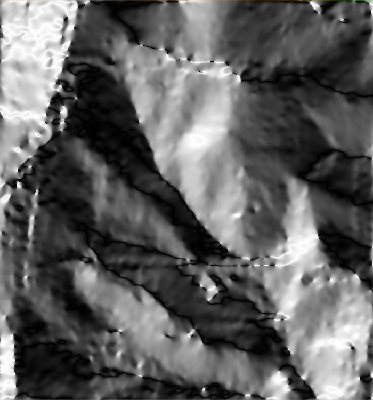

In [8]:
# Create Map instance
asp_rst_t40_map = gj.Map(filename="output/asp_rst_t40.png")
asp_rst_t40_map.d_rast(map="elev_rstdef_1m")
asp_rst_t40_map.d_rast(map="asp_rstdef_1m")
# Display map
asp_rst_t40_map.show()

Display Tension 10

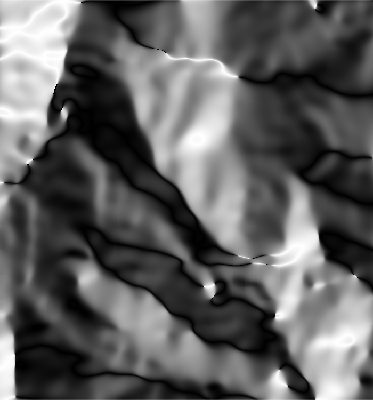

In [9]:
# Create Map instance
asp_rst_t10_map = gj.Map(filename="output/asp_rst_t10.png")
asp_rst_t10_map.d_rast(map="asp_rstt10_1m")
# Display map
asp_rst_t10_map.show()

Display Tension 160

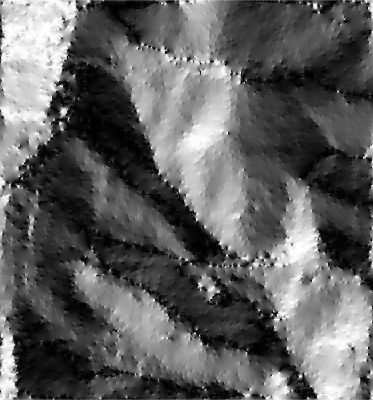

In [10]:
# Create Map instance
asp_rst_t160_map = gj.Map(filename="output/asp_rst_t160.png")
asp_rst_t160_map.d_rast(map="asp_rstt160_1m")
# Display map
asp_rst_t160_map.show()

>  Or use 3D views of elev_rstdef_1m, elev_rstt10_1m, elev_rstt160_1m, make sure you switch off the aspect rasters and save the 3 images for your report. 

### Compute elevation raster and deviations vector point map

- For different values of smoothing compare deviation stats for smoothing 0.1 and 10.
- Find root mean square deviation rmse. 

In [11]:
%%bash
v.surf.rst input=elev_lid792_randpts elevation=elev_rstdef_1mb zcolumn=value smooth=0.1 deviations=elev_rstdef_devi segmax=30 npmin=140
v.build elev_rstdef_devi
v.surf.rst input=elev_lid792_randpts elevation=elev_rstsm10_1mb zcolumn=value smooth=10 deviations=elev_rstsm10_devi segmax=30 npmin=140
v.build elev_rstsm10_devi
v.info -c elev_rstdef_devi
v.univar elev_rstdef_devi column=flt1 type=point
r.info elev_rstdef_1mb
v.info -c elev_rstsm10_devi
v.univar elev_rstsm10_devi column=flt1 type=point
r.info elev_rstsm10_1mb

Reading features from vector map ...
Processing all selected output files will require
2.01 MB of disk space for temp files.
Processing segments in parallel...
Starting parallel work
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Building topology for vector map <elev_rstdef_devi@HW_interpolation_1>...
Registering primitives...
v.surf.rst complete.
Building topology for vector map <elev_rstdef_devi@HW_interpolation_1>...
Registering primitives...
Reading features from vector map ...
Processing all selected output files will require
2.01 MB of disk space for temp files.
Processing segments in parallel...
Starting parallel work
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Bui

INTEGER|cat
DOUBLE PRECISION|flt1


   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100


number of features with non NULL attribute: 6000
number of missing attributes: 0
number of NULL attributes: 0
minimum: -0.042607
maximum: 0.05454
range: 0.097147
sum: 0.148153
mean: 2.46922e-05
mean of absolute values: 0.0038907
population standard deviation: 0.00584874
population variance: 3.42078e-05
population coefficient of variation: 236.866
sample standard deviation: 0.00584923
sample variance: 3.42135e-05
kurtosis: 8.62674
skewness: 0.460314
 +----------------------------------------------------------------------------+
 | Map:      elev_rstdef_1mb                Date: Sun Nov 20 14:10:54 2022    |
 | Mapset:   HW_interpolation_1             Login of Creator: coreywhite      |
 | Location: nc_spm_08_grass7                                                 |
 | DataBase: /home/coreywhite/Documents/grassdata                             |
 | Title:                                                                     |
 | Timestamp: none                                                 

Displaying column types/names for database connection of layer <1>:


INTEGER|cat
DOUBLE PRECISION|flt1


   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100


number of features with non NULL attribute: 6000
number of missing attributes: 0
number of NULL attributes: 0
minimum: -0.711146
maximum: 1.40478
range: 2.11593
sum: 15.4109
mean: 0.00256848
mean of absolute values: 0.119597
population standard deviation: 0.167814
population variance: 0.0281614
population coefficient of variation: 65.3358
sample standard deviation: 0.167828
sample variance: 0.0281661
kurtosis: 6.0696
skewness: 1.10237
 +----------------------------------------------------------------------------+
 | Map:      elev_rstsm10_1mb               Date: Sun Nov 20 14:10:57 2022    |
 | Mapset:   HW_interpolation_1             Login of Creator: coreywhite      |
 | Location: nc_spm_08_grass7                                                 |
 | DataBase: /home/coreywhite/Documents/grassdata                             |
 | Title:                                                                     |
 | Timestamp: none                                                            |
 

Compute and display deviations maps using same color table. You need to use custom color table to see the results well.

Note that we are interpolating here the deviations, not the given elevations. 

In [12]:
%%bash
v.surf.rst input=elev_rstdef_devi elevation=elev_rstdef_devi zcolumn=flt1 segmax=30 npmin=140
v.surf.rst input=elev_rstsm10_devi elevation=elev_rstsm10_devi zcolumn=flt1 segmax=30 npmin=140

Reading features from vector map ...
Processing all selected output files will require
2.01 MB of disk space for temp files.
Processing segments in parallel...
Starting parallel work
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78WARNING: Overshoot - increase in tension suggested. Overshoot occurs at
         (375,212) cell. Z-value 0.066484, zmin -0.042607, zmax 0.054540.
  80  82  84  86  88  90  92  94  96  98 100
v.surf.rst complete.
Reading features from vector map ...
Processing all selected output files will require
2.01 MB of disk space for temp files.
Processing segments in parallel...
Starting parallel work
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
v.surf.rst complete.


Apply the downloaded color table deviations_color.txt to the deviation raster.

Optionally, to view the results in 3D use "elev_rstdef_1mb" for elevation (switch off everything else) and drape the deviations maps as color. 

In [15]:
%%bash
r.colors elev_rstsm10_devi rules=inputs/deviations_color.txt
r.colors elev_rstdef_devi raster=elev_rstsm10_devi

Color table for raster map <elev_rstsm10_devi> set to
'inputs/deviations_color.txt'
Color table for raster map <elev_rstdef_devi> set to 'elev_rstsm10_devi'


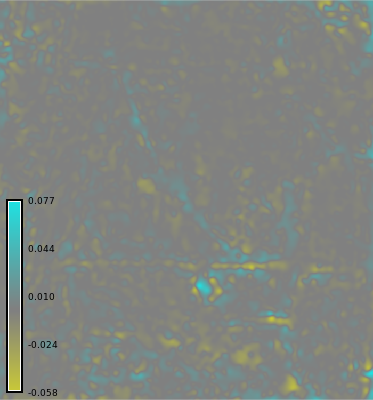

In [16]:
# Create Map instance
elev_rstsm10_devi_map = gj.Map(filename="output/elev_rstdef_devi.png")
elev_rstsm10_devi_map.d_rast(map="elev_rstdef_devi")
# Set legend
elev_rstsm10_devi_map.d_legend(raster="elev_rstdef_devi", at=[2,50,2,6])
# Display map
elev_rstsm10_devi_map.show()

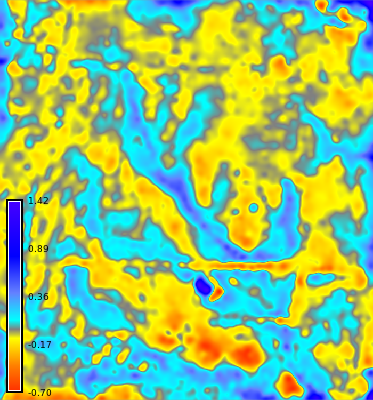

In [17]:
# Create Map instance
elev_rstsm10_devi_map = gj.Map(filename="output/elev_rstsm10_devi.png")
elev_rstsm10_devi_map.d_rast(map="elev_rstdef_devi")
elev_rstsm10_devi_map.d_rast(map="elev_rstsm10_devi")
# Set legend
elev_rstsm10_devi_map.d_legend(raster="elev_rstsm10_devi", at=[2,50,2,6])
# Display map
elev_rstsm10_devi_map.show()

### Compute predictive error of interpolation

Compute predictive error of interpolation for each point using cross-validation (no raster output, only points with pred. errors). 

In [96]:
%%bash
v.surf.rst -c input=elev_lid792_randpts zcolumn=value cvdev=elev_rstdef_cv npmin=120 segmax=35
v.build elev_rstdef_cv
v.univar elev_rstdef_cv column=flt1 type=point

Reading features from vector map ...
Processing all selected output files will require
0 bytes of disk space for temp files.
Processing segments in parallel...
Starting parallel work
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Building topology for vector map <elev_rstdef_cv@HW_interpolation_2>...
Registering primitives...
v.surf.rst complete. 300     400     500     600     700     800     900    1000    1100    1200    1300    1400
Building topology for vector map <elev_rstdef_cv@HW_interpolation_2>...
Registering primitives...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100


number of features with non NULL attribute: 144085
number of missing attributes: 0
number of NULL attributes: 0
minimum: -1.09116
maximum: 1.71507
range: 2.80622
sum: 6317.4
mean: 0.0438449
mean of absolute values: 0.296103
population standard deviation: 0.429462
population variance: 0.184437
population coefficient of variation: 9.79501
sample standard deviation: 0.429463
sample variance: 0.184438
kurtosis: 1.68037
skewness: 0.919602


Compute raster map of predictive errors and **identify locations where the sampling is inadequate.**

Optionally, to view the result in 3D use "elev_rstdef_1mb" for elevation (switch off everything else) and drape the crossvalidation map "elev_rstdef_cv" as color. 

In [97]:
%%bash
v.surf.rst input=elev_rstdef_cv elevation=elev_rstdef_cv zcolumn=flt1
r.colors elev_rstdef_cv raster=elev_rstsm10_devi

Reading features from vector map ...
Ignoring 138085 points (too dense)
Processing all selected output files will require
2.01 MB of disk space for temp files.
Processing segments in parallel...
Starting parallel work
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84WARNING: Overshoot - increase in tension suggested. Overshoot occurs at
         (533,264) cell. Z-value 2.025044, zmin -1.091157, zmax 1.715066.
  86  88  90  92  94  96  98 100
v.surf.rst complete.
Color table for raster map <elev_rstdef_cv> set to 'elev_rstsm10_devi'


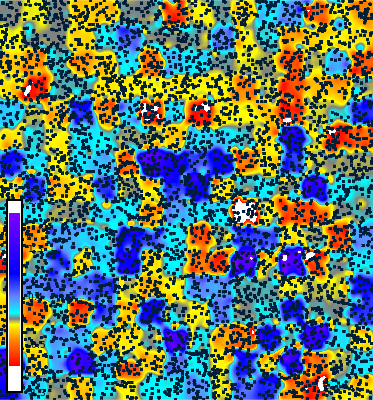

In [98]:
# Create Map instance
elev_rstdef_cv_map = gj.Map(filename="output/elev_rstdef_cv.png")
elev_rstdef_cv_map.d_rast(map="elev_rstdef_cv")
elev_rstdef_cv_map.d_vect(map="elev_rstdef_cv", size=2)
# Set legend
elev_rstdef_cv_map.d_legend(raster="elev_rstdef_cv", at=[2,50,2,6])
# Display map
elev_rstdef_cv_map.show()

### Interpolate precipitation with influence of topography

- Set the 3D region (read the man page for [g.region](https://grass.osgeo.org/grass76/manuals/g.region.html)).
- We set tbres to high value 
    > we have just a single level because we are not computing the 3D raster (see lecture for more details). 

In [99]:
%%bash
g.region raster=elev_state_500m -p
g.region t=2000 b=0 tbres=2000 res3=500 -p3

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      318500
south:      -16000
west:       124000
east:       963000
nsres:      500
ewres:      500
rows:       669
cols:       1678
cells:      1122582
projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      318500
south:      -16000
west:       124000
east:       963000
top:        2000.00000000
bottom:     0.00000000
nsres:      500
nsres3:     500
ewres:      500
ewres3:     500
tbres:      2000
rows:       669
rows3:      669
cols:       1678
cols3:      1678
depths:     1
cells:      1122582
cells3:     1122582


Compute precipitation raster map without influence of elevation (with segmax=700 segmentation is not performed so interpolation function is computed using all points at once).
We will use mask during the interpolation. 

In [100]:
%%bash
r.mask raster=ncmask_500m
v.info -c precip_30ynormals
v.surf.rst input=precip_30ynormals elevation=precip_annual_500m zcolumn=annual segmax=700

All subsequent raster operations will be limited to the MASK area. Removing
or renaming raster map named 'MASK' will restore raster operations to
normal.
Displaying column types/names for database connection of layer <1>:


INTEGER|cat
DOUBLE PRECISION|station
DOUBLE PRECISION|lat
DOUBLE PRECISION|long
DOUBLE PRECISION|elev
DOUBLE PRECISION|jan
DOUBLE PRECISION|feb
DOUBLE PRECISION|mar
DOUBLE PRECISION|apr
DOUBLE PRECISION|may
DOUBLE PRECISION|jun
DOUBLE PRECISION|jul
DOUBLE PRECISION|aug
DOUBLE PRECISION|sep
DOUBLE PRECISION|oct
DOUBLE PRECISION|nov
DOUBLE PRECISION|dec
DOUBLE PRECISION|annual


Reading features from vector map ...
         given NPMIN=300
         is necessary, to run the program faster set segmax=600 (see
         manual)
Processing all selected output files will require
4.28 MB of disk space for temp files.
Bitmap mask created
Processing segments in parallel...
Starting parallel work
   0 100
v.surf.rst complete.


Use the downloaded the color table precip_color.txt.

Zoom to computational region when displaying the result. 

In [101]:
!r.colors precip_annual_500m rules=inputs/precip_color.txt

Color table for raster map <precip_annual_500m> set to
'inputs/precip_color.txt'


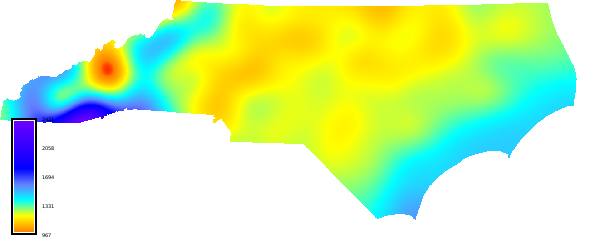

In [102]:
# Create Map instance
precip_annual_500m_map = gj.Map(filename="output/precip_annual_500m.png")
precip_annual_500m_map.d_rast(map="precip_annual_500m")
# Set legend
precip_annual_500m_map.d_legend(raster="precip_annual_500m", at=[2,50,2,6])
# Display map
precip_annual_500m_map.show()

Compute precipitation raster map with elevation. 

There is both 3D voxel output and 2D raster output - we want the 2D raster output (cross_output).

Optionally to view the results in 3D, switch off everything except for elev_state_500m and precip_30ynormals_3d,
switch to 3D, set(type in) viewer height at 300000, z-exag at 6, fine res=1,
use precip_anntopo_500m for color, set icon size for points - sphere, 5000.
Display the result and save the image for the report. 

In [103]:
%%bash
v.info -c precip_30ynormals_3d
v.vol.rst input=precip_30ynormals_3d cross_input=elev_state_500m cross_output=precip_anntopo_500m maskmap=elev_state_500m wcolumn=annual zscale=90 segmax=700
r.colors precip_anntopo_500m raster=precip_annual_500m

Displaying column types/names for database connection of layer <1>:


INTEGER|cat
DOUBLE PRECISION|station
DOUBLE PRECISION|lat
DOUBLE PRECISION|long
DOUBLE PRECISION|elev
DOUBLE PRECISION|jan
DOUBLE PRECISION|feb
DOUBLE PRECISION|mar
DOUBLE PRECISION|apr
DOUBLE PRECISION|may
DOUBLE PRECISION|jun
DOUBLE PRECISION|jul
DOUBLE PRECISION|aug
DOUBLE PRECISION|sep
DOUBLE PRECISION|oct
DOUBLE PRECISION|nov
DOUBLE PRECISION|dec
DOUBLE PRECISION|annual


136 records selected from table
Processing all selected output files will require 0 bytes of disk space for
temp files

         given NPMIN=200
Bitmap mask created
   0 100
Finished interpolating
Raster map <precip_anntopo_500m> created

The number of points in vector map is 136
The number of points outside of 2D/3D region 0
The number of points used (after reduction) is 136
Color table for raster map <precip_anntopo_500m> set to
'precip_annual_500m'


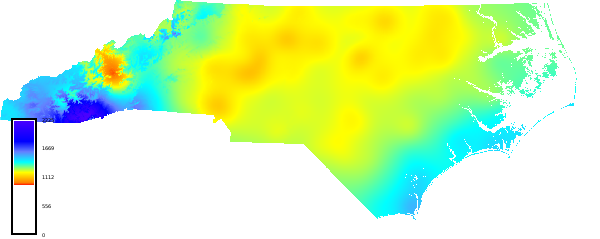

In [104]:
# Create Map instance
precip_anntopo_500m_map = gj.Map(filename="output/precip_anntopo_500m.png")
precip_anntopo_500m_map.d_rast(map="precip_anntopo_500m")
# Set legend
precip_anntopo_500m_map.d_legend(raster="precip_anntopo_500m", at=[2,50,2,6])
# Display map
precip_anntopo_500m_map.show()

**Try to explain how was elevation used for the precipitation raster interpolation.** 

After you are finished, remove mask. 

In [106]:
!r.mask -r

Raster MASK removed
